In [2]:
import os

import pandas as pd
import torch
import torch.nn as nn
from datasets import Dataset
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoConfig
from transformers import AutoModel, AutoTokenizer
from transformers import Trainer, TrainingArguments
import json

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

C:\Users\nishi\PythonProject\ImageForensics\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [8]:
def get_company_dataset(company, tokenizer, max_length=128, test_size=0.2):
    df = pd.read_csv(f"{company}_data_v2.csv")

    #  Label Encoding (Local to this company/dataset)
    # If global consistency needed across companies, pass fitted encoders instead.
    type_encoder = LabelEncoder()
    code_encoder = LabelEncoder()

    df['cc_type_id'] = type_encoder.fit_transform(df['cc_type'])
    df['cc_code_id'] = code_encoder.fit_transform(df['cc_code'])

    type_id_to_label = {str(i): str(label) for i, label in enumerate(type_encoder.classes_)}
    code_id_to_label = {str(i): str(label) for i, label in enumerate(code_encoder.classes_)}

    with open(f'type_id_to_label_{company}.json', 'w') as f:
        json.dump(type_id_to_label, f)

    with open(f'code_id_to_label_{company}.json', 'w') as f:
        json.dump(code_id_to_label, f)

    # Calculate dimensions for the model heads
    num_type_labels = len(type_encoder.classes_)
    num_code_labels = len(code_encoder.classes_)

    print(f"Dataset Loaded: {len(df)} records")
    print(f"Found {num_type_labels} Transaction Types and {num_code_labels} GL Codes.")

    # 3. Stratified Train/Test Split
    # We create a temporary 'stratify_col' to ensure both Type and Code distributions are preserved
    df['stratify_col'] = df['cc_type'].astype(str) + "_" + df['cc_code'].astype(str)

    train_df, val_df = train_test_split(
        df,
        test_size=test_size,
        random_state=42,
        stratify=df['stratify_col']  # Critical for rare GL codes
    )
    #company_a_data_40classes.csv
    train_df.to_csv(f"Training_Data_{company}.csv", index=False)
    val_df.to_csv(f"Val_Data_{company}.csv", index=False)

    val_metadata = val_df[['merchant_group', 'merchant_name','merchant_category', 'amount', 'currency', 'description', 'cc_type', 'cc_code']].reset_index(drop=True)

    # Cleanup auxiliary columns
    cols_to_keep = ['merchant_group', 'merchant_name','merchant_category', 'amount', 'currency',  'cc_type_id', 'cc_code_id']
    train_df = train_df[cols_to_keep]
    val_df = val_df[cols_to_keep]

    # 4. Convert to Hugging Face Datasets
    train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
    val_dataset = Dataset.from_pandas(val_df, preserve_index=False)

    # 5. Tokenization Function
    def preprocess_function(examples):
        # Manual concatenation for Qwen/LLMs
        inputs = [
            f"Merchant: {name} | Group: {group} | Category: {cat} | Amount: {amt} | currency: {curr} "
            for name, group, cat, amt, curr in zip(
                examples["merchant_name"],
                examples["merchant_group"],
                examples["merchant_category"],
                examples["amount"],
                examples["currency"],
               )
             ]

        tokenized_inputs = tokenizer(
            inputs,  # Single list of strings
            truncation=True,
            max_length=max_length,
            padding="max_length"  # Or False if using DataCollator
        )

        tokenized_inputs["labels_type"] = examples["cc_type_id"]
        tokenized_inputs["labels_code"] = examples["cc_code_id"]
        return tokenized_inputs

    # 6. Apply Processing
    # We remove the text columns to leave only the tensors
    remove_cols = train_dataset.column_names

    train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=remove_cols)
    val_dataset = val_dataset.map(preprocess_function, batched=True, remove_columns=remove_cols)

    # 7. Set Format for PyTorch
    target_columns = ["input_ids", "attention_mask", "labels_type", "labels_code"]
    train_dataset.set_format(type="torch", columns=target_columns)
    val_dataset.set_format(type="torch", columns=target_columns)

    return {
        "train": train_dataset,
        "val": val_dataset,
        "val_metadata": val_metadata,
        "num_type_labels": num_type_labels,
        "num_code_labels": num_code_labels,
        "encoders": {"type": type_encoder, "code": code_encoder}

    }


In [3]:
from transformers import AutoModelForCausalLM


class QwenMultiHeadClassifier(nn.Module):
    def __init__(self, model_id, num_type_labels, num_code_labels,  lora_config=None):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_id)

        self.qwen = AutoModelForCausalLM.from_pretrained(
            model_id,
            trust_remote_code=True,
            device_map=None
        )


        # print(f"VANILLA QWEN ARCHITECTURE : \n {self.qwen}")

        if lora_config is not None:
            self.qwen = get_peft_model(self.qwen, lora_config)

            self.qwen.print_trainable_parameters()

        # Two separate Head for Code and Type , hiodeen size of model , 1536 for Qwen .

        self.type_head = nn.Linear(self.config.hidden_size, num_type_labels)
        self.code_head = nn.Linear(self.config.hidden_size, num_code_labels)

        self.type_head.weight.data.normal_(mean=0.0, std=0.001) # Tiny std dev
        self.type_head.bias.data.zero_()

        self.code_head.weight.data.normal_(mean=0.0, std=0.001)
        self.code_head.bias.data.zero_()
        # changing heads added to QWEN Data Type DFloat16 
        self.type_head.to(self.qwen.dtype)
        self.code_head.to(self.qwen.dtype)

        self.loss_fn = nn.CrossEntropyLoss()

    def can_generate(self):
            return False

    def forward(self, input_ids, attention_mask=None,
                labels_type=None, labels_code=None, labels=None, **kwargs):

        if labels is not None:
            labels_type = labels[:, 0]  # Assuming first col is type
            labels_code = labels[:, 1]  # Assuming second col is code

        outputs = self.qwen(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=True
        )
        # Extract Last Token Embedding (EOS token), for LLMs, use Last Hidden State of last token
        # shape : [batch, seq_length, hidden]
        # AutoModelForCausalLM might not return 'last_hidden_state' attribute directly in some versions,
        # but 'hidden_states' tuple is always there if output_hidden_states=True.

        if hasattr(outputs, "last_hidden_state"):
            last_hidden_state = outputs.last_hidden_state
        else:
            # Fallback: Get the last layer from the hidden_states tuple
            last_hidden_state = outputs.hidden_states[-1]

        #print( "Shape of last hidden state %",last_hidden_state.shape )
        #Shape of last hidden state = torch.Size([32, 64, 1536])
        # Get Embedding of last token for Classification
        if self.config.pad_token_id is None:  # Fallback if no pad token
            sequence_lengths = -1
        else:
            if input_ids is not None:  # Find last non paddign token
                sequence_lengths = (torch.ne(input_ids, self.config.pad_token_id).sum(-1) - 1).to(
                    last_hidden_state.device)
            else:
                sequence_lengths = -1

        # Get the Vector for last token in the sequence using sequence lenght calced above
        #last_hidden_state shape: (Batch_Size, Sequence_Length, Hidden_Size)
        # last_hidden_state[0] = batch size
        # sequence_lengths contains last token indexes for each sequence .
        # Last token is sequence is like CLS token it has learnt about the sequence
        pooled_output = last_hidden_state[torch.arange(last_hidden_state.shape[0]), sequence_lengths]

        # Pass it to the linear layers like we do CLS Token in Transforemrs
        logits_type = self.type_head(pooled_output)
        logits_code = self.code_head(pooled_output)

        loss = None

        if labels_type is not None and labels_code is not None:
            loss_type = self.loss_fn(logits_type, labels_type)
            loss_code = self.loss_fn(logits_code, labels_code)
            loss = 2 * loss_type + 1 * loss_code
        else:
            loss = torch.tensor(0.0, device=input_ids.device, requires_grad=True)

        # Form output that can work with Huggingface trainer
        output = {
            "logits": (logits_type, logits_code)
        }

        return loss, logits_type, logits_code



In [4]:
import numpy as np
import evaluate

class CustomTrainer(Trainer):
    def save_model(self, output_dir=None, _internal_call=False):
        # Save the LoRA adapters (standard behavior)
        # Checks if model is wrapped in PEFT
        if output_dir is None:
            output_dir = self.args.output_dir

        # Save LoRA weights
        self.model.qwen.save_pretrained(output_dir)

        # MANUALLY save your custom heads
        torch.save(self.model.type_head.state_dict(), f"{output_dir}/type_head.bin")
        torch.save(self.model.code_head.state_dict(), f"{output_dir}/code_head.bin")

        # Save tokenizer
        self.tokenizer.save_pretrained(output_dir)

# 1. Load the metrics you want
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    # Unpack predictions and labels
    predictions, labels = eval_pred
    print("COMPUTE METRICS CALLED")
    # Handle tuple output from your model (logits_type, logits_code)
    if isinstance(predictions, tuple):
        logits_type = predictions[0]
        logits_code = predictions[1]
    else:
        logits_type, logits_code = predictions

    # Get predicted classes
    pred_types = np.argmax(logits_type, axis=1)
    pred_codes = np.argmax(logits_code, axis=1)

    # Extract true labels
    true_types = labels[:, 0]
    true_codes = labels[:, 1]

    # Calculate accuracies
    acc_type = accuracy_score(true_types, pred_types)
    acc_code = accuracy_score(true_codes, pred_codes)

    # IMPORTANT: You must return a dictionary!
    return {
        "accuracy_type": acc_type,
        "accuracy_code": acc_code,
        "combined_accuracy": (acc_type + acc_code) / 2
    }

def preprocess_logits_for_metrics(logits, labels):
    # Ensure this returns a tuple/tensor, NOT None!
    if isinstance(logits, tuple):
        return (logits[1], logits[2]) # (logits_type, logits_code)
    # Fallback debug
    print(f"DEBUG: preprocess received {type(logits)}")
    return logits


In [9]:
model_id = "Qwen/Qwen2.5-0.5B"
local_model_path = "./models/Qwen1.5-0.5B-Base"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

print(f"Downloading {model_id}...")

# 2. Download and Save Model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True
)
model.save_pretrained(local_model_path)


tokenizer.save_pretrained(local_model_path)

print(f"✅ Model saved to: {local_model_path}")

companies = ["company_a", "company_b", "company_c"]  #  list of companies,  "company_E", "company_F"

data_bundle_company_a = get_company_dataset("company_a", tokenizer)
data_bundle_company_b = get_company_dataset("company_b", tokenizer)
data_bundle_company_c = get_company_dataset("company_c", tokenizer)


import joblib

# ... (inside your training loop, after creating data_bundle) ...
print(f"Saving data bundle for companies...")
joblib.dump(data_bundle_company_a, "data_bundle_company_a_v2.pkl")
joblib.dump(data_bundle_company_b, "data_bundle_company_b_v2.pkl")
joblib.dump(data_bundle_company_c, "data_bundle_company_c_v2.pkl")

peft_config = LoraConfig(
    #treat the Qwen backbone as a feature extractor.as we have custom multihead QWEN ,
    # normal classification this would have been SEQ_CLS
    # classification heads are external to the PEFT wrapper here
    task_type=TaskType.CAUSAL_LM,
    r=16,  # 16 RANk is good , LORA Mattrices will be A X R and R X B .
    lora_alpha=32,
    # Scales Output of Lora adapter by Alpha / Rank . ( 32/16 for us) , Makes learnt weights LOUDER compared to base model weights .
    #Scale of 2 is good .
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    # Q K V and Output Projections selected to train as part of adapter
    # MLP Layers are gate_proj, up_proj, down_proj , but results in very large number of paramters to learn but also gives huge accuracy benefit .
    lora_dropout=0.05  # Prevents overfittig whern data sizes are small like our company data case.
)

Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


✅ Model saved to: ./models/Qwen1.5-0.5B-Base
Dataset Loaded: 2000 records
Found 18 Transaction Types and 16 GL Codes.


Map: 100%|██████████| 400/400 [00:00<00:00, 25163.06 examples/s]


Dataset Loaded: 2000 records
Found 19 Transaction Types and 17 GL Codes.


Map: 100%|██████████| 400/400 [00:00<00:00, 24681.81 examples/s]


Dataset Loaded: 2000 records
Found 15 Transaction Types and 17 GL Codes.


Map: 100%|██████████| 400/400 [00:00<00:00, 25736.27 examples/s]

Saving data bundle for companies...


In [6]:

# 4. Training Loop
for company in companies:
    print(f"Training adapter for: {company}")
    # Format: "Merchant Group: {grp} [SEP] Merchant Name: {name}"
    if company == "company_a":
        data_bundle = data_bundle_company_a
    elif company == "company_b":
        data_bundle = data_bundle_company_b
    elif company == "company_c":
        data_bundle = data_bundle_company_c

    train_dataset = data_bundle["train"]
    val_dataset = data_bundle["val"]
    num_type_labels = data_bundle["num_type_labels"]
    num_code_labels = data_bundle["num_code_labels"]

    model = QwenMultiHeadClassifier(
        model_id=model_id,
        num_type_labels=num_type_labels,
        num_code_labels=num_code_labels,
        lora_config=peft_config
    )

    #model.qwen.resize_token_embeddings(len(tokenizer))

    for param in model.type_head.parameters(): param.requires_grad = True
    for param in model.code_head.parameters(): param.requires_grad = True

    # C. Train
    training_args = TrainingArguments(
    output_dir=f"./results/{company}",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=1,
    num_train_epochs=10,
    learning_rate=5e-4,
    warmup_steps=50,
    max_grad_norm=0.3,
        # Strategy
    #eval_strategy="epoch",
    save_strategy="no",
    logging_steps=200,

    # Best Model Selection
    #load_best_model_at_end=True,
   # metric_for_best_model="eval_combined_accuracy",  # ✅ Matches key in compute_metrics
   # greater_is_better=True,                     # ✅ Accuracy: higher is better
   # save_total_limit=1,                         # Save disk space

    # Critical for custom models
    remove_unused_columns=False,

)

    custom_trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset = val_dataset,
        compute_metrics=compute_metrics,
        preprocess_logits_for_metrics=preprocess_logits_for_metrics
    )

    custom_trainer.train()
    print(f"Peak memory: {torch.cuda.max_memory_allocated()/1e9:.2f} GB")

    metrics = custom_trainer.evaluate(eval_dataset=val_dataset)
    print(metrics)

    save_path = f"./final_adapters_QWEN_0_5_v2/{company}"

    # Save Adapter & Heads
    # This saves the LoRA weights
    model.qwen.save_pretrained(save_path)
    torch.save(model.type_head.state_dict(), os.path.join(save_path, "type_head.bin"))
    torch.save(model.code_head.state_dict(), os.path.join(save_path, "code_head.bin"))

     # 6. Clean up
    del model
    torch.cuda.empty_cache()


Training adapter for: company_a


Loading weights: 100%|██████████| 290/290 [00:00<00:00, 944.72it/s, Materializing param=model.norm.weight]                              


trainable params: 2,162,688 || all params: 496,195,456 || trainable%: 0.4359


Step,Training Loss
200,2.879380
400,0.000107


Peak memory: 8.60 GB


{'eval_runtime': 12.8072, 'eval_samples_per_second': 31.232, 'eval_steps_per_second': 0.547, 'epoch': 10.0}


C:\Users\nishi\PythonProject\ImageForensics\.venv\Lib\site-packages\peft\utils\save_and_load.py:309: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Training adapter for: company_b


Loading weights: 100%|██████████| 290/290 [00:00<00:00, 915.26it/s, Materializing param=model.norm.weight]                               


trainable params: 2,162,688 || all params: 496,195,456 || trainable%: 0.4359


Step,Training Loss
200,2.668770
400,0.000178


Peak memory: 8.60 GB


{'eval_runtime': 43.3953, 'eval_samples_per_second': 9.218, 'eval_steps_per_second': 0.161, 'epoch': 10.0}
Training adapter for: company_c


Loading weights: 100%|██████████| 290/290 [00:00<00:00, 1408.41it/s, Materializing param=model.norm.weight]                              


trainable params: 2,162,688 || all params: 496,195,456 || trainable%: 0.4359


Step,Training Loss
200,3.024757
400,0.000496


Peak memory: 8.60 GB


{'eval_runtime': 13.6185, 'eval_samples_per_second': 29.372, 'eval_steps_per_second': 0.514, 'epoch': 10.0}


In [5]:
model_id = "Qwen/Qwen2.5-0.5B"

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
peft_config = LoraConfig(
    #treat the Qwen backbone as a feature extractor.as we have custom multihead QWEN ,
    # normal classification this would have been SEQ_CLS
    # classification heads are external to the PEFT wrapper here
    task_type=TaskType.CAUSAL_LM,
    r=16,  # 16 RANk is good , LORA Mattrices will be A X R and R X B .
    lora_alpha=32,
    # Scales Output of Lora adapter by Alpha / Rank . ( 32/16 for us) , Makes learnt weights LOUDER compared to base model weights .
    #Scale of 2 is good .
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    # Q K V and Output Projections selected to train as part of adapter
    # MLP Layers are gate_proj, up_proj, down_proj , but results in very large number of paramters to learn but also gives huge accuracy benefit .
    lora_dropout=0.05  # Prevents overfittig whern data sizes are small like our company data case.
)

Loading Base Model (this takes time)...


Loading weights: 100%|██████████| 290/290 [00:00<00:00, 1487.51it/s, Materializing param=model.norm.weight]                              


Fetching data for company_a...
Loading cached data bundle for company_a...

--- Validating: company_a ---
Loading heads -> Types: 18, Codes: 16
Running Inference...


✅ Predictions saved to: predictions_company_a.csv

--- Prediction Sample for company_a ---
Idx   Merchant                       Act. Code            Pred. Code           Match
-------------------------------------------------------------------------------------
0     Merchant_1083 OTE              COMPANY_A-246316     COMPANY_A-246316     ✅    
1     Merchant_1629 AFI              COMPANY_A-198246     COMPANY_A-198246     ✅    
2     Merchant_563 VMN               COMPANY_A-334053     COMPANY_A-334053     ✅    
3     Merchant_2036 ABQ              COMPANY_A-246316     COMPANY_A-246316     ✅    
4     Merchant_772 AKF               COMPANY_A-872246     COMPANY_A-872246     ✅    
5     Merchant_443 OGU               COMPANY_A-671858     COMPANY_A-671858     ✅    
6     Merchant_4630 PNY              COMPANY_A-207473     COMPANY_A-207473     ✅    
7     Merchant_580 BGG               COMPANY_A-246316     COMPANY_A-246316     ✅    
8     Merchant_656 FZB               COMPANY_A-877572     

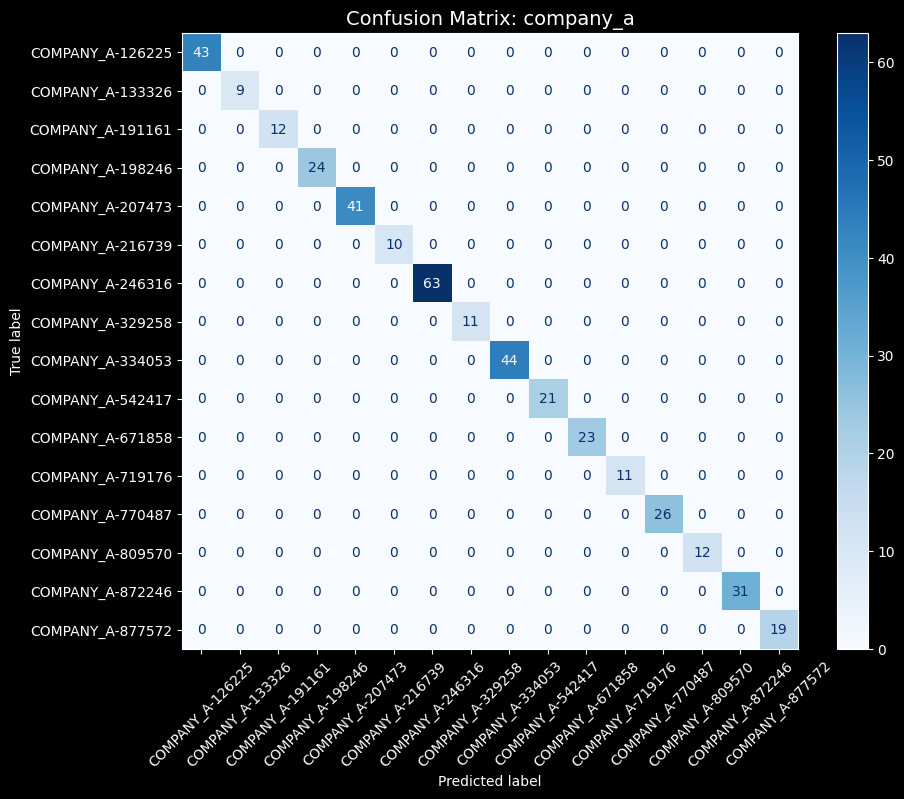

⚠️ Could not plot confusion matrix: y contains previously unseen labels: [16 17]
Fetching data for company_b...
Loading cached data bundle for company_b...

--- Validating: company_b ---
Loading heads -> Types: 19, Codes: 17


C:\Users\nishi\PythonProject\ImageForensics\.venv\Lib\site-packages\peft\tuners\tuners_utils.py:1466: UserWarning: Adapter company_a was active which is now deleted. Setting active adapter to default.
  warnings.warn(


Running Inference...


✅ Predictions saved to: predictions_company_b.csv

--- Prediction Sample for company_b ---
Idx   Merchant                       Act. Code            Pred. Code           Match
-------------------------------------------------------------------------------------
0     Merchant_4060 OXF              COMPANY_B-708067     COMPANY_B-708067     ✅    
1     Merchant_3303 OAA              COMPANY_B-810725     COMPANY_B-810725     ✅    
2     Merchant_4490 EXQ              COMPANY_B-154321     COMPANY_B-154321     ✅    
3     Merchant_2181 IUH              COMPANY_B-154321     COMPANY_B-154321     ✅    
4     Merchant_3075 TSV              COMPANY_B-895474     COMPANY_B-895474     ✅    
5     Merchant_1203 WEI              COMPANY_B-105851     COMPANY_B-105851     ✅    
6     Merchant_4763 IXO              COMPANY_B-895474     COMPANY_B-895474     ✅    
7     Merchant_3601 ZSP              COMPANY_B-895474     COMPANY_B-895474     ✅    
8     Merchant_3303 OAA              COMPANY_B-810725     

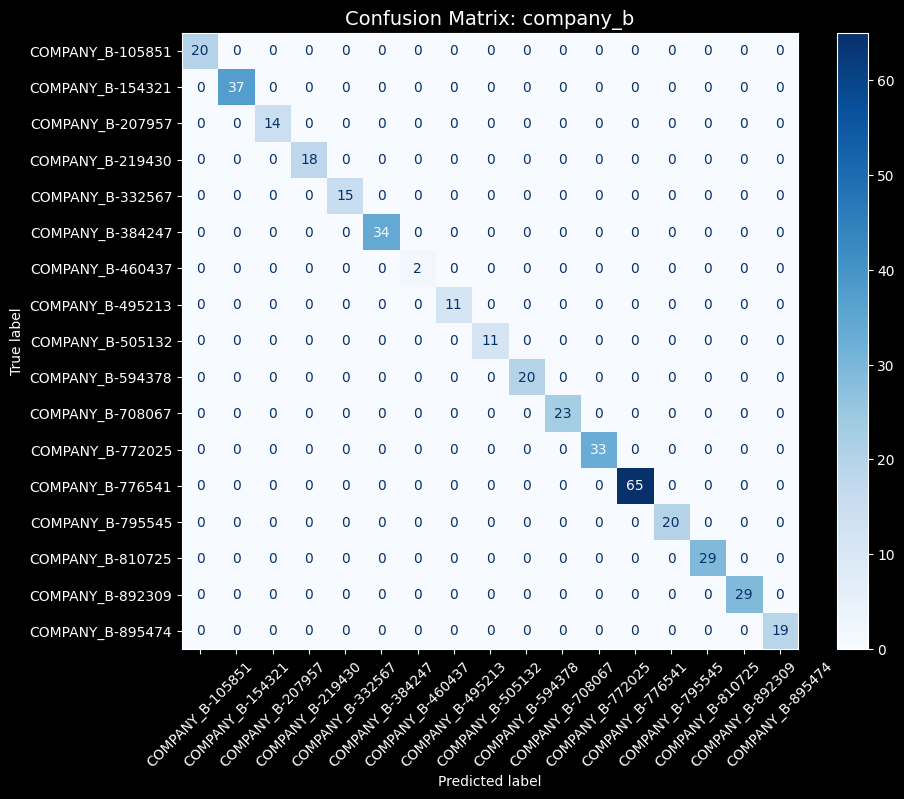

⚠️ Could not plot confusion matrix: y contains previously unseen labels: [17 18]
Fetching data for company_c...
Loading cached data bundle for company_c...

--- Validating: company_c ---
Loading heads -> Types: 15, Codes: 17


C:\Users\nishi\PythonProject\ImageForensics\.venv\Lib\site-packages\peft\tuners\tuners_utils.py:1466: UserWarning: Adapter company_b was active which is now deleted. Setting active adapter to default.
  warnings.warn(


Running Inference...


✅ Predictions saved to: predictions_company_c.csv

--- Prediction Sample for company_c ---
Idx   Merchant                       Act. Code            Pred. Code           Match
-------------------------------------------------------------------------------------
0     Merchant_1089 LRR              COMPANY_C-993329     COMPANY_C-993329     ✅    
1     Merchant_1904 OXU              COMPANY_C-608678     COMPANY_C-608678     ✅    
2     Merchant_4645 MHS              COMPANY_C-160189     COMPANY_C-160189     ✅    
3     Merchant_4375 ZXZ              COMPANY_C-725545     COMPANY_C-725545     ✅    
4     Merchant_1339 OBK              COMPANY_C-892494     COMPANY_C-892494     ✅    
5     Merchant_2271 VNW              COMPANY_C-520557     COMPANY_C-520557     ✅    
6     Merchant_740 SNZ               COMPANY_C-993329     COMPANY_C-993329     ✅    
7     Merchant_2640 CEO              COMPANY_C-142907     COMPANY_C-142907     ✅    
8     Merchant_2514 GJH              COMPANY_C-725545     

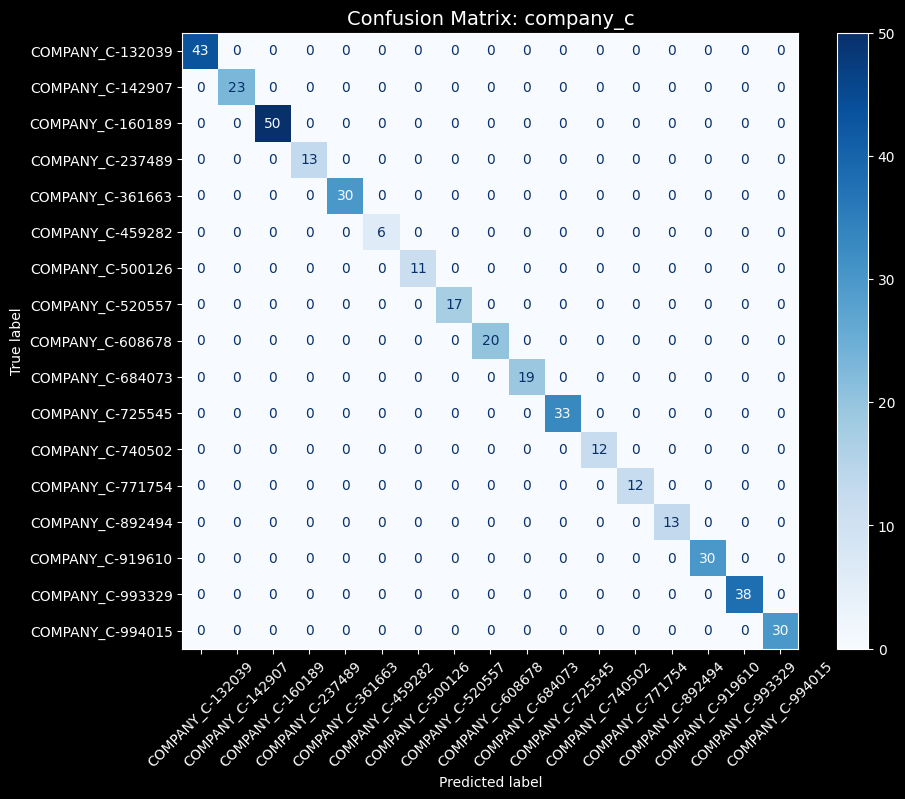

Generating Confusion Matrix for GL Types...


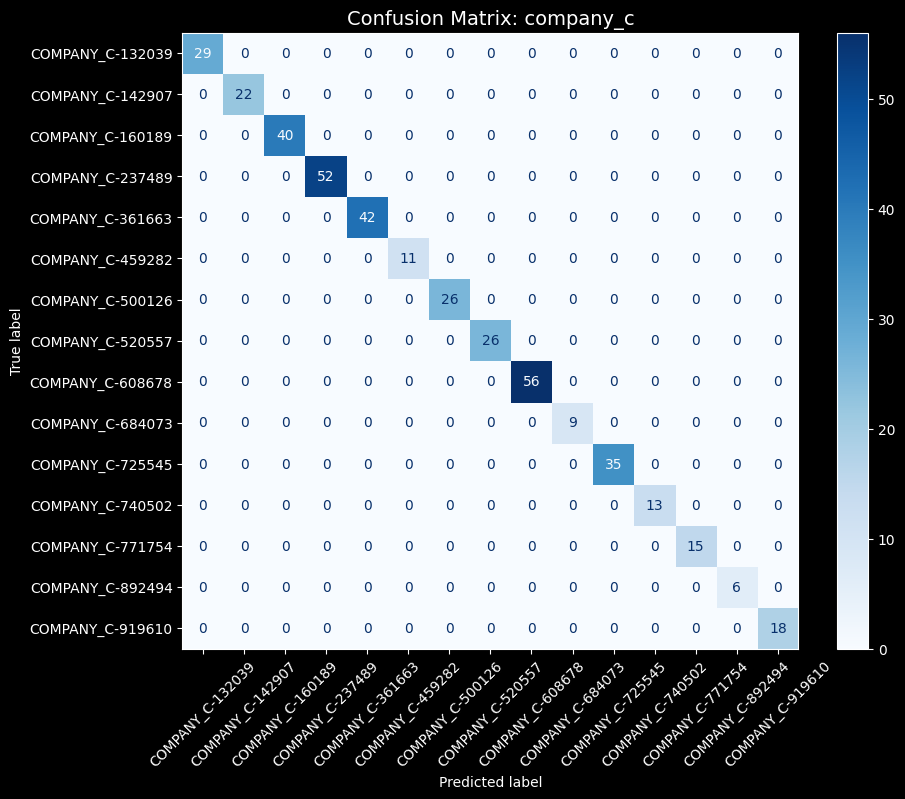


=== Final Results Summary ===
[{'company': 'company_a', 'acc_code': 1.0}, {'company': 'company_b', 'acc_code': 1.0}, {'company': 'company_c', 'acc_code': 1.0}]


C:\Users\nishi\PythonProject\ImageForensics\.venv\Lib\site-packages\peft\tuners\tuners_utils.py:1466: UserWarning: Adapter company_c was active which is now deleted. Setting active adapter to default.
  warnings.warn(


In [6]:
import torch
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModel
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
    ConfusionMatrixDisplay
import joblib

def preprocess_logits_for_metrics(logits, labels):
   return logits[1], logits[2]


# Initialize Base Model Wrapper ONCE
print("Loading Base Model (this takes time)...")
# Note: Ensure QwenMultiHeadClassifier class definition is available above this block
base_model_wrapper = QwenMultiHeadClassifier(
    model_id=model_id,
    num_type_labels=2,  # Dummy
    num_code_labels=2  # Dummy
)

# CRITICAL FIXES
base_model_wrapper.qwen.resize_token_embeddings(len(tokenizer))
base_model_wrapper.qwen = get_peft_model(base_model_wrapper.qwen, peft_config)
base_model_wrapper.to("cuda")  # Move to GPU


def plot_cm(cm, class_names, title):
    """
    Robust Confusion Matrix Plotter
    """
    # Ensure class names match the matrix size
    # If validation set is small, some classes might be missing from y_true or y_pred
    # confusion_matrix in sklearn returns a matrix of size [n_unique_labels, n_unique_labels]
    # We must trust the labels passed to it.

    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Filter for readability if too many classes
    if len(class_names) > 20:
        plt.title(f"{title} (Showing subset)", fontsize=14)
        disp.plot(ax=ax, cmap='Blues', xticks_rotation=45, include_values=False)
    else:
        plt.title(title, fontsize=14)
        disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
    plt.show()


# --- 2. Validation Function ---
def validate_company(model, company_name, adapters_root_dir, val_dataset, val_metadata, encoders):
    print(f"\n--- Validating: {company_name} ---")
    adapter_path = os.path.join(adapters_root_dir, company_name)

    if not os.path.exists(adapter_path):
        print(f"❌ Adapter path not found: {adapter_path}")
        return None

    # A. Dynamic Head Resizing (Crucial Step)
    try:
        # Load state dicts to CPU first
        type_state = torch.load(os.path.join(adapter_path, "type_head.bin"), map_location="cpu")
        code_state = torch.load(os.path.join(adapter_path, "code_head.bin"), map_location="cpu")

        n_types = type_state['weight'].shape[0]
        n_codes = code_state['weight'].shape[0]

        print(f"Loading heads -> Types: {n_types}, Codes: {n_codes}")

        # Resize the linear layers on the model
        dtype = model.qwen.dtype
        device = model.qwen.device

        model.type_head = torch.nn.Linear(model.config.hidden_size, n_types).to(device=device, dtype=dtype)
        model.code_head = torch.nn.Linear(model.config.hidden_size, n_codes).to(device=device, dtype=dtype)

        # Load weights
        model.type_head.load_state_dict(type_state)
        model.code_head.load_state_dict(code_state)

    except FileNotFoundError:
        print(f"❌ Skipping {company_name}: Head weights (bin files) not found.")
        return None

    # B. Load LoRA Adapter
    try:
        # Only load if not already loaded (avoid duplicates error)
        if company_name not in model.qwen.peft_config:
            model.qwen.load_adapter(adapter_path, adapter_name=company_name)

        model.qwen.set_adapter(company_name)
    except Exception as e:
        print(f"❌ Skipping {company_name}: Adapter load failed. {e}")
        return None

    # C. Inference
    eval_trainer = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir="./temp_eval",
            per_device_eval_batch_size=32,
            remove_unused_columns=False,
            report_to="none",
            # Optimization: Use float16 if GPU supports it
            fp16=torch.cuda.is_available()
        ),
        preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    )

    print("Running Inference...")
    preds = eval_trainer.predict(val_dataset, ignore_keys=["loss", "hidden_states", "attentions"])
    logits_type, logits_code = preds.predictions

    # D. Metrics & DataFrame Construction
    pred_types = np.argmax(logits_type, axis=1)
    pred_codes = np.argmax(logits_code, axis=1)

    # Get ground truth from Dataset (guaranteed to be aligned with inputs)
    true_types = np.array(val_dataset['labels_type'])
    true_codes = np.array(val_dataset['labels_code'])

    # Encoders for decoding
    type_encoder = encoders["type"]
    code_encoder = encoders["code"]

    # --- DATAFRAME CREATION ---
    # Important: val_metadata MUST be the exact dataframe used to create val_dataset
    # If val_dataset was shuffled independently, this will be mismatched.
    # Assuming get_company_dataset returns them aligned.

    predictions_df = pd.DataFrame({
        'merchant_name': val_metadata['merchant_name'].values,  # Use .values to ignore index mismatch
        'merchant_group': val_metadata['merchant_group'].values,
        'actual_type_str': val_metadata['cc_type'].values,
        'actual_code_str': val_metadata['cc_code'].values,
        'pred_type_id': pred_types,
        'pred_code_id': pred_codes,
        'true_type_id': true_types,
        'true_code_id': true_codes
    })

    # Add decoded strings
    # Handle cases where predicted ID might be out of range of encoder (rare bug check)
    try:
        predictions_df['pred_type_str'] = type_encoder.inverse_transform(pred_types)
        predictions_df['pred_code_str'] = code_encoder.inverse_transform(pred_codes)
    except ValueError as e:
        print(f"⚠️ Decoding Error: {e}. Check if encoders match the model training!")
        predictions_df['pred_type_str'] = "ERROR"
        predictions_df['pred_code_str'] = "ERROR"

    predictions_df['type_correct'] = predictions_df['pred_type_id'] == predictions_df['true_type_id']
    predictions_df['code_correct'] = predictions_df['pred_code_id'] == predictions_df['true_code_id']

    # Save to CSV
    output_file = f"predictions_{company_name}.csv"
    predictions_df.to_csv(output_file, index=False)
    print(f"✅ Predictions saved to: {output_file}")

    # --- PRINT SAMPLE ---
    print(f"\n--- Prediction Sample for {company_name} ---")
    print(f"{'Idx':<5} {'Merchant':<30} {'Act. Code':<20} {'Pred. Code':<20} {'Match':<5}")
    print("-" * 85)
    for idx in range(min(10, len(predictions_df))):
        row = predictions_df.iloc[idx]
        match = "✅" if row['code_correct'] else "❌"
        print(
            f"{idx:<5} {str(row['merchant_name'])[:28]:<30} {str(row['actual_code_str'])[:18]:<20} {str(row['pred_code_str'])[:18]:<20} {match:<5}")

    # --- METRICS CALCULATION ---
    # Zero Division=0 handles cases where a class is never predicted
    p_code = precision_score(true_codes, pred_codes, average='weighted', zero_division=0)
    r_code = recall_score(true_codes, pred_codes, average='weighted', zero_division=0)
    f1_code = f1_score(true_codes, pred_codes, average='weighted', zero_division=0)
    acc_code = accuracy_score(true_codes, pred_codes)

    p_type= precision_score(true_types, pred_types, average='weighted', zero_division=0)
    r_type = recall_score(true_types, pred_types, average='weighted', zero_division=0)
    f1_type = f1_score(true_types, pred_types, average='weighted', zero_division=0)
    acc_type = accuracy_score(true_types, pred_types)

    print(f"\n=== GL Codes Metrics ({company_name}) ===")
    print(f"Accuracy:  {acc_code:.4f}  {acc_type:.4f}  ")
    print(f"Precision: {p_code:.4f}  {p_type:.4f}  ")
    print(f"Recall:    {r_code:.4f}  {r_type:.4f}  ")
    print(f"F1 Score:  {f1_code:.4f}  {f1_type:.4f}  ")

    # --- CONFUSION MATRIX ---
    # Only compute if we have a manageable number of classes or for debugging
    unique_true_codes = sorted(list(set(true_codes)))
    unique_pred_codes = sorted(list(set(pred_codes)))
    all_labels_present_codes = sorted(list(set(unique_true_codes + unique_pred_codes)))

    unique_true_types = sorted(list(set(true_types)))
    unique_pred_types = sorted(list(set(pred_types)))
    all_labels_present_types = sorted(list(set(unique_true_types + unique_pred_types)))

    # We map these IDs back to strings for the plot labels
    try:
        label_names = code_encoder.inverse_transform(all_labels_present_codes)
        cm_code = confusion_matrix(true_codes, pred_codes, labels=all_labels_present_codes)
        print("Generating Confusion Matrix for GL Codes...")
        plot_cm(cm_code, label_names, f"Confusion Matrix: {company_name}")

        label_names_type = code_encoder.inverse_transform(all_labels_present_types)
        cm_code_type = confusion_matrix(true_types, pred_types, labels=all_labels_present_types)
        print("Generating Confusion Matrix for GL Types...")
        plot_cm(cm_code_type, label_names_type, f"Confusion Matrix: {company_name}")

    except Exception as e:
        print(f"⚠️ Could not plot confusion matrix: {e}")

    # E. Cleanup
    try:
        # Delete adapter to free memory for next company
        model.qwen.delete_adapter(company_name)
    except:
        pass  # Ignore if delete fails

    torch.cuda.empty_cache()  # Clear GPU memory

    return {"company": company_name, "acc_code": acc_code}


# --- 3. Execution Loop ---
results = []
companies = ["company_a",  "company_b", "company_c"]  # Add "company_E", "company_F" as needed

for company in companies:
    # 1. Get Data Bundle (Ensure this returns 'val', 'val_metadata', 'encoders')
    print(f"Fetching data for {company}...")
    bundle_path = f"data_bundle_{company}_v2.pkl"

    if os.path.exists(bundle_path):
        print(f"Loading cached data bundle for {company}...")
        data_bundle = joblib.load(bundle_path)


    # 2. Validate
    res = validate_company(
        model=base_model_wrapper,
        company_name=company,
        adapters_root_dir="./final_adapters_QWEN_0_5_v2",
        val_dataset=data_bundle['val'],
        val_metadata=data_bundle["val_metadata"],
        encoders=data_bundle["encoders"]
    )

    if res:
        results.append(res)


print("\n=== Final Results Summary ===")
print(results)
